In [1]:
import random

import himalaya.scoring
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV, Ridge
from sklearn.linear_model import LinearRegression

from simulation import generate_dataset

In [2]:
set_backend('cupy', on_error='warn')
backend = get_backend()
plt.style.use('nord')
sns.set_theme(style='whitegrid')
random.seed(42)

In [3]:
d_list = [100, 100, 100]
scalars = [1 / 3, 1 / 3, 1 / 3]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 100
n_samples = n_samples_train + n_samples_test
noise_scalar = 0.1

In [4]:
alphas = np.logspace(-4, 4, 10)
cv = 10
score_func = himalaya.scoring.r2_score
use_ols = False
i_from = 0
i_to = 1

In [5]:
Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_scalar, construction_method="orthogonal")

first of all lets verify that Ridge regression with $\alpha = 0$ indeed is equivalent to linear regression

In [6]:
ridge = Ridge(alpha=1, solver_params=dict(warn=False, n_targets_batch=1000))
ridge.fit(Xs[0][:n_samples_train], Y[:n_samples_train])
ridge_coef = ridge.coef_  # (n_features, n_targets)

In [7]:
linear = LinearRegression()
linear.fit(backend.to_numpy(Xs[0][:n_samples_train]), backend.to_numpy(Y[:n_samples_train]))
linear_coef = linear.coef_  # (n_targets, n_features)
# swap rows and columns
linear_coef = linear_coef.T

In [21]:
print((backend.to_numpy(ridge_coef) - np.array(linear_coef)).mean())
print((backend.to_numpy(ridge_coef) - np.array(linear_coef)).max())
print((backend.to_numpy(ridge_coef) - np.array(linear_coef)).min())
# sns.displot(backend.to_numpy(linear_coef) - backend.to_numpy(ridge_coef))

-2.5841695e-09
0.00011653209
-0.00010243151



compute on full feature sets for comparison

0.5837315
0.58321595


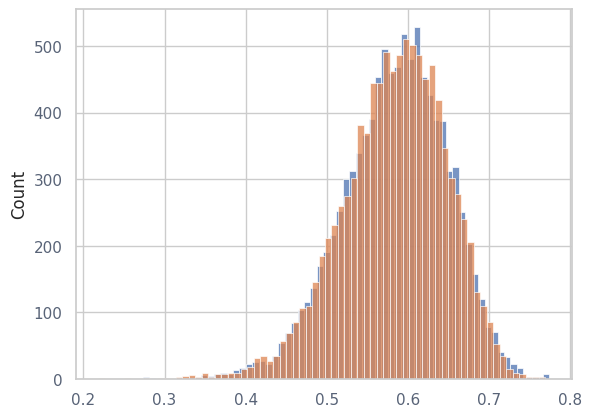

In [9]:
full_scores = []
for i in range(len(Xs)):
    full_model = RidgeCV(alphas=alphas, cv=cv,
                         solver_params=dict(warn=False, score_func=score_func, n_targets_batch=1000))
    full_model.fit(Xs[i][:n_samples_train], Y[:n_samples_train])
    full_score = full_model.score(Xs[i][n_samples_train:], Y[n_samples_train:])
    print(full_score.mean())
    full_scores.append(full_score)
    sns.histplot(backend.to_numpy(full_score))

# Feature to feature regression

In [10]:
if use_ols:
    feature_model = Ridge(alpha=1, solver_params=dict(warn=False, n_targets_batch=1000))
else:
    feature_model = RidgeCV(alphas=alphas, cv=cv, solver_params=(
        dict(warn=False, score_func=score_func, n_targets_batch=1000)))

In [11]:
feature_model.fit(Xs[i_from][:n_samples_train], Xs[i_to][:n_samples_train])

RidgeCV(alphas=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
        cv=10,
        solver_params={'n_targets_batch': 1000,
                       'score_func': <function r2_score at 0x7a85a33c8b80>,
                       'warn': False})

In [22]:
X_predict_train = feature_model.predict(Xs[i_from][:n_samples_train])
X_predict_test = feature_model.predict(Xs[i_from][n_samples_train:])

In [23]:
X_predict_train = backend.asarray(X_predict_train)
X_predict_test = backend.asarray(X_predict_test)

<Axes: ylabel='Count'>

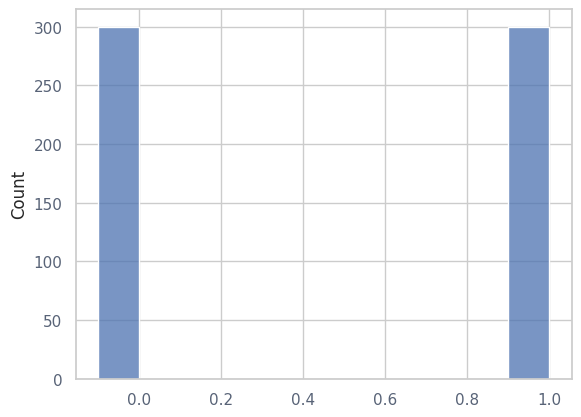

In [24]:
feature_score = feature_model.score(Xs[i_from][n_samples_train:], Xs[i_to][n_samples_train:])
sns.histplot(backend.to_numpy(feature_score))

Compute residuals

In [25]:
X_residual_train = Xs[i_to][:n_samples_train] - X_predict_train
X_residual_test = Xs[i_to][n_samples_train:] - X_predict_test

# Train residual model

0.30542374


<Axes: ylabel='Count'>

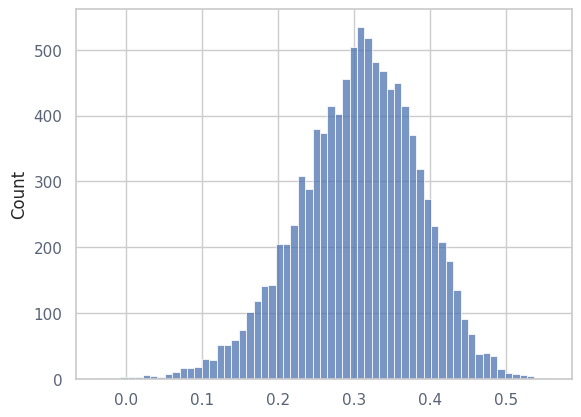

In [26]:
residual_model = RidgeCV(alphas=alphas, cv=cv,
                         solver_params=dict(warn=False, score_func=score_func, n_targets_batch=1000))
residual_model.fit(X_residual_train, Y[:n_samples_train])
residual_score = residual_model.score(X_residual_test, Y[n_samples_train:])
print(residual_score.mean())
sns.histplot(backend.to_numpy(residual_score))

In [27]:
full_scores = list(map(backend.to_numpy, full_scores))
feature_score = backend.to_numpy(feature_score)
residual_score = backend.to_numpy(residual_score)

Text(0.0, 1.0, 'Residual Method')

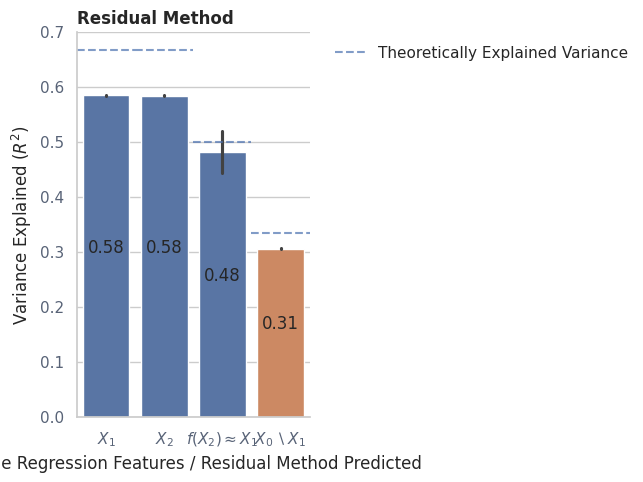

In [35]:
import pandas as pd

fig, ax = plt.subplots(figsize=(3, 5))

scores = pd.DataFrame(
    # create columnar data
    [full_scores[0], full_scores[1], feature_score, residual_score],
    index=[r"$X_1$", "$X_2$", fr"$f(X_{i_from + 1})\approx X_{i_to + 1}$", rf"$X_{i_to} \setminus X_{i_from}$"]
)
p = sns.barplot(
    data=scores.T,
    palette=["C0", "C0", "C0", "C1"],  # Define colors: one for joint/X₁/X₂, one for unique/shared
    ax=ax
)
sns.despine(fig)

# Add lines indicating the maximum possible height for each bar
theoretical_scores = [scalars[0] + scalars[1], scalars[0] + scalars[2], d_list[0] / (d_list[0] + d_list[i_to]), scalars[i_to + 1]]

for idx, score in enumerate(theoretical_scores):  # iterate over rows in the DataFrame
    xmin = idx / len(theoretical_scores)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(theoretical_scores)  # Calculate xmax for each bar
    plt.axhline(score, linestyle='--', alpha=0.7, xmin=xmin, xmax=xmax,
                label=fr'Theoretically Explained Variance' if idx == 0 else "")

# add values to center of bar charts
for idx, column in enumerate(scores.index):
    plt.text(idx, scores.loc[column].mean() / 2,
             f"{scores.loc[column].mean():.2f}", ha='center', va='bottom')

# Ensure the legend is displayed properly
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel(r"Variance Explained $(R^2)$")
plt.xlabel("Ridge Regression Features / Residual Method Predicted")
plt.title("Residual Method")